## 머신러닝 모델 선정 및 검증

#### Preliminary Step

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [2]:
import matplotlib.pyplot as plt

# 윈도우 예시: 'Malgun Gothic' (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 음수 깨짐 방지 (예: -값이 깨져보일 수 있음)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv('제조AI데이터셋_(주)코넥.csv',encoding="cp949")

In [4]:
df = df.drop(["Unnamed: 0", "싸이클타임(sec)"],axis=1)

In [5]:
df

,저속속도(m/s),고속속도(m/s),고속절환위치(mm),고속구간(mm),주조압력(MPa),탕구두께(mm),승압시간(ms),스프레이(sec),형체력(%),진공도(mmHg),보온로(℃),에어압력,냉각수온도,냉각수압력,대기온도,대기습도,불량여부
0,0.340000,2.190000,708,201,68.700000,31,102,18.500000,98,742,666,6.420000,21.667000,3.928000,17.471000,61.838000,1
1,0.340000,2.190000,709,199,68.800000,31,102,18.500000,98,741,666,6.433000,21.667000,3.957000,17.492000,61.809000,1
2,0.340000,2.200000,695,210,68.400000,35,125,18.500000,97,738,670,6.297000,19.000000,3.689000,17.671000,64.666000,1
3,0.340000,2.190000,696,210,68.500000,35,122,18.500000,97,739,670,6.243000,19.000000,3.705000,17.737000,64.543000,1
4,0.340000,2.190000,706,202,68.700000,34,118,18.500000,98,738,670,6.287000,19.000000,3.728000,17.875000,64.825000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87283,0.340000,2.232041,689,226,71.420407,34,84,18.100000,98,738,658,6.344081,28.554217,3.812919,34.842239,56.733446,1
87284,0.340000,2.200000,695,220,71.100000,30,71,18.411622,92,736,669,6.523947,25.705702,4.170765,30.343448,74.228078,1
87285,0.345732,2.102804,710,211,72.857321,29,67,17.400000,99,738,668,6.860072,23.000000,4.180121,22.671038,65.282479,1
87286,0.350000,2.120000,709,212,73.000000,30,66,17.400000,99,738,668,6.877349,22.000000,4.267018,22.153813,66.859814,1


#### Distribution and Scaling

In [6]:
# y, X
X = df.drop(columns=["불량여부"])
y = df["불량여부"].astype(int)

# Type Classification
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Pre-processing Pipeline
    # Numeric : Median + Standardization (for stable logistic learning)
    # Catecorical : Mean + One-hot encoding (for unlisted category)
    
num_tf = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')), # 결측치 채워주는 전처리 도구
    ('scaler', StandardScaler())
])
cat_tf = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ('num', num_tf, num_cols),
    ('cat', cat_tf, cat_cols)
])

# Scaling
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
) 

# Baseline / Logistic / RandomForest
    # class_weight = balanced 
    # Logistic = ElasticNet
    # RF = To be robust without tuning, interactivity
    
pipe_dummy = Pipeline([
    ('pre', preprocessor),
    ('clf', DummyClassifier(strategy='most_frequent')) # 바닥선, 실제 모델이 이보다 좋아야 한다.
])

pipe_logit = Pipeline([
    ("pre", preprocessor),
    ('clf', LogisticRegression(
        penalty='elasticnet', solver='saga',
        l1_ratio = 0.5, C = 1.0, max_iter = 5000,
        class_weight = 'balanced', random_state = 42
    ))
])

pipe_rf = Pipeline([
    ("pre", preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=400,   # 300 ~ 600
        max_depth=None,     # 10 ~ 24
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        n_jobs=-1,         # 멀티코어 병렬
        class_weight='balanced_subsample',
        random_state=42
    ))
])



In [7]:
from sklearn.metrics import roc_auc_score

# 누수 체크
# 단일 피처 예측

for col in X.columns:
    auc = roc_auc_score(y, X[col])
    print(col, auc)
    
# 특정 변수 하나만으로 AUC ≈ 1.0 
# → 그 변수는 타겟과 거의 직접적인 매핑 관계일 가능성 큼.
# 누수 없음!

저속속도(m/s) 0.3945881306485705
고속속도(m/s) 0.633605822331877
고속절환위치(mm) 0.4895588231322724
고속구간(mm) 0.4795633230092609
주조압력(MPa) 0.28208533733508306
탕구두께(mm) 0.5146094875926042
승압시간(ms) 0.5585779137140293
스프레이(sec) 0.7152282791099038
형체력(%) 0.4181042075198017
진공도(mmHg) 0.4809947836924646
보온로(℃) 0.5617504066319372
에어압력 0.6043618657672188
냉각수온도 0.5528909304673121
냉각수압력 0.6545171723066494
대기온도 0.5340284793742114
대기습도 0.6700990298221198


In [8]:
# Fitting & Evaluation (based on prob')
    # ROC-AUC = 전반 분류력
    # PR-AUC = Average precision 불균형 시 유용
    
def fit_and_eval(pipe, name):
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_te)[:,1]
    roc = roc_auc_score(y_te, proba)
    pr = average_precision_score(y_te, proba)
    print(f"[{name}] ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")
    return pipe, proba, {"roc": roc, "pr": pr}

pipe_dummy, proba_d, m_dummy = fit_and_eval(pipe_dummy, "Dummy")
pipe_logit, proba_l, m_logit = fit_and_eval(pipe_logit, "Logistics")
pipe_rf, proba_r, m_rf = fit_and_eval(pipe_rf, "RandomForest")


[Dummy] ROC-AUC=0.5000 | PR-AUC=0.5000
[Logistics] ROC-AUC=0.9661 | PR-AUC=0.9675
[RandomForest] ROC-AUC=0.9999 | PR-AUC=0.9999


In [9]:
# Best Model Evaluation (PR-AUC)

scores = {'Dummy': m_dummy['pr'], 'Logistic': m_logit['pr'], 'RF': m_rf['pr']}
best_name = max(scores, key = scores.get) # 최고 PR-AUC 모델 이름
best_pipe = {"Dummy": pipe_dummy, "Logistic": pipe_logit, "RF": pipe_rf}[best_name]
best_proba = {"Dummy": proba_d, "Logistic": proba_l, "RF": proba_r}[best_name]
print(f"\n>> 적합 베이스 모델: {best_name} (PR-AUC={scores[best_name]:.4f})")

# Threshold Tuning
    # Precision_recall_curve : 다양한 임곗값(precision, recall, threshold) 제공
    # Recall >= Target recall & Best precision

prec, rec, thr = precision_recall_curve(y_te, best_proba)
thr_full = np.r_[thr, 1.0]
cands = [(p, r, t) for p, r, t in zip(prec, rec, thr_full) if  r >= 0.5]

if cands:
    # 재현율 조건을 만족하는 후보 중 정밀도가 가장 높은 임곗값 선택
    bp, br, bt = max(cands, key=lambda x: x[0])
else:
    # 조건 달성 불가 시, PR 곡선의 마지막 점(모델 상태 그대로) 사용
    bp, br, bt = prec[-1], rec[-1], thr_full[-1]

print(f"\n>> [임곗값] threshold={bt:.3f} → Precision={bp:.3f}, Recall={br:.3f}")


>> 적합 베이스 모델: RF (PR-AUC=0.9999)

>> [임곗값] threshold=0.993 → Precision=1.000, Recall=0.880


In [10]:
# 최종 예측(이진) 생성 및 리포트
y_pred = (best_proba >= bt).astype(int)
print("\n[혼동행렬]")
print(confusion_matrix(y_te, y_pred))
print("\n[분류 리포트]")
print(classification_report(y_te, y_pred, digits=3)) 
# threshold 0.993 이상으로 올려서 FP 값을 낮추기
# 양품을 틀렸다고 한다면 그 뒤에 불량품이 날 조건 직전이라는 의미일 수도 있다.
# 불량품 발생을 사전에 방지 가능할 듯?


[혼동행렬]
[[10911     0]
 [ 1310  9601]]

[분류 리포트]
              precision    recall  f1-score   support

           0      0.893     1.000     0.943     10911
           1      1.000     0.880     0.936     10911

    accuracy                          0.940     21822
   macro avg      0.946     0.940     0.940     21822
weighted avg      0.946     0.940     0.940     21822



In [14]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
print(f"Accuracy: {accuracy_score(y_te, y_pred):.4f}")
print(f"F1-score: {f1_score(y_te, y_pred):.4f}")
print(f"ROC-AUC : {roc_auc_score(y_te, y_pred):.4f}")

Accuracy: 0.9400
F1-score: 0.9361
ROC-AUC : 0.9400


In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
# ❗ You MUST import the model class 
from sklearn.ensemble import RandomForestClassifier 

# Create an INSTANCE (object) of the model
# You can add parameters like random_state for reproducibility
model = RandomForestClassifier(n_estimators=100, random_state=42) 

# Cross Validation on ROC-AUC

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pass the INSTANCE (model) to cross_val_score, not the class (RandomForestClassifier)
# 🚫 Incorrect: scores = cross_val_score(RandomForestClassifier, X, y, cv=skf, scoring="roc_auc")
scores = cross_val_score(model, X, y, cv=skf, scoring="roc_auc") 

print("CV AUC:", scores.mean(), scores.std())

CV AUC: 0.9999224805363298 3.301872144198097e-05


In [11]:
# Permutation Importance
    #  - 파이프라인(best_pipe)을 그대로 두고, 테스트 입력 X_te의 '원래' 컬럼 하나씩 무작위 섞음
    #  - 섞였을 때 PR-AUC가 얼마나 떨어지는지(평균 하락량)로 해당 컬럼의 중요도 계산
    #  - 장점: 원-핫으로 쪼개지지 않고 "원본 컬럼" 기준의 해석이 가능
    #  - n_repeats: 반복 섞기 횟수(클수록 안정하지만 느림; 5~10 권장)
    #  - scoring="average_precision": PR-AUC 기준으로 영향 측정
    
print("\n[Permutation Importance 상위 20 — scoring=average_precision]")
perm = permutation_importance(
    best_pipe, X_te, y_te,
    n_repeats=8,                      # 반복 횟수(시간 vs 안정성 트레이드오프)
    random_state=42,
    scoring="average_precision"
)
pi = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print(pi.head(20))


[Permutation Importance 상위 20 — scoring=average_precision]
저속속도(m/s)     0.049575
에어압력          0.020889
보온로(℃)        0.008025
냉각수압력         0.006392
형체력(%)        0.004023
탕구두께(mm)      0.003975
스프레이(sec)     0.003069
진공도(mmHg)     0.001436
승압시간(ms)      0.001398
주조압력(MPa)     0.001187
고속속도(m/s)     0.000253
고속구간(mm)      0.000203
냉각수온도         0.000147
대기습도          0.000127
대기온도          0.000112
고속절환위치(mm)    0.000085
dtype: float64


#### RF Bagging

In [22]:
from sklearn.datasets import make_moons, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import numpy as np

In [23]:
# RF Bagging

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, max_depth=None, max_features="sqrt", oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_tr, y_tr)
print(rf.oob_score_)

# 고분산 데이터에 적합한 모델이다. 
# 변수가 크게 분산이 안되어 있으므로 부적합

0.996333974887728


In [24]:
print(f"Accuracy: {accuracy_score(y_te, y_pred):.4f}")
print(f"F1-score: {f1_score(y_te, y_pred):.4f}")
print(f"ROC-AUC : {roc_auc_score(y_te, y_pred):.4f}")

Accuracy: 0.9934
F1-score: 0.9933
ROC-AUC : 0.9934


In [46]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=skf, scoring="roc_auc")
print("CV AUC:", scores.mean(), scores.std())


CV AUC: 0.9999298118539764 3.5925337315948644e-05


#### RF Gradient Boosting

In [15]:
# RF Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=800, max_depth=3, random_state=42)
gb.fit(X_tr, y_tr)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=800,
                           random_state=42)

In [16]:
y_pred = gb.predict(X_te)

print("=== 분류 예제 ===")
print("Accuracy:", accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred, digits=3))

=== 분류 예제 ===
Accuracy: 0.993355329484007
              precision    recall  f1-score   support

           0      0.988     0.999     0.993     10911
           1      0.999     0.988     0.993     10911

    accuracy                          0.993     21822
   macro avg      0.993     0.993     0.993     21822
weighted avg      0.993     0.993     0.993     21822



In [17]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
print(f"Accuracy: {accuracy_score(y_te, y_pred):.4f}")
print(f"F1-score: {f1_score(y_te, y_pred):.4f}")
print(f"ROC-AUC : {roc_auc_score(y_te, y_pred):.4f}")

Accuracy: 0.9934
F1-score: 0.9933
ROC-AUC : 0.9934


In [20]:
print("MSE:", mean_squared_error(y_te, y_pred))
print("R^2 :", r2_score(y_te, y_pred))

MSE: 0.006644670515993035
R^2 : 0.9734213179360278


In [47]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(gb, X, y, cv=skf, scoring="roc_auc")
print("CV AUC:", scores.mean(), scores.std())

CV AUC: 0.9994975327690808 0.00012367284679552746


In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier   

#### AdaBoost

In [20]:
# scikit-learn AdaBoost
print("\n=== scikit-learn AdaBoost ===")

# 1) AdaBoost 분류기 정의
ada_sklearn = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),  
    # 약분류기(weak learner) → 깊이 1짜리 의사결정나무 (decision stump)
    # 구버전 호환 때문에 'estimator' 대신 'base_estimator'로 쓰이던 시절도 있음.

    n_estimators=100,
    # 약분류기를 100개 만들어서 앙상블 (반복 횟수)

    learning_rate=0.1,
    # 각 단계에서 모델이 업데이트되는 크기 (학습률)
    # 작게 주면 천천히 학습, 크게 주면 빠르지만 불안정할 수 있음

    algorithm="SAMME",
    # AdaBoost 알고리즘 버전
    # - "SAMME" : 다중 분류 지원 (확률 대신 단순 vote 기반)
    # - "SAMME.R" : 확률 기반으로 조금 더 효율적 (보통 기본값)

    random_state=42
    # 랜덤 시드 고정
)

# 2) 모델 학습
ada_sklearn.fit(X_tr, y_tr)

# 3) 예측
sklearn_pred = ada_sklearn.predict(X_te)

# 4) 정확도 평가
sklearn_accuracy = accuracy_score(y_te, sklearn_pred)
print(f"scikit-learn AdaBoost 정확도: {sklearn_accuracy:.4f}")

# 5) 분류 리포트 출력 (precision, recall, f1-score 포함)
print("\n분류 리포트:")
print(classification_report(y_te, sklearn_pred))


=== scikit-learn AdaBoost ===


c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


scikit-learn AdaBoost 정확도: 0.8286

분류 리포트:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     10911
           1       0.97      0.68      0.80     10911

    accuracy                           0.83     21822
   macro avg       0.86      0.83      0.82     21822
weighted avg       0.86      0.83      0.82     21822



In [21]:
print(f"Accuracy: {accuracy_score(y_te, sklearn_pred):.4f}")
print(f"F1-score: {f1_score(y_te, sklearn_pred):.4f}")
print(f"ROC-AUC : {roc_auc_score(y_te, sklearn_pred):.4f}")

Accuracy: 0.8286
F1-score: 0.7984
ROC-AUC : 0.8286


In [48]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ada_sklearn, X, y, cv=skf, scoring="roc_auc")
print("CV AUC:", scores.mean(), scores.std())

c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is depr

CV AUC: 0.9267428226332722 0.001816202165460619


#### CatBoost

In [ ]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from catboost import CatBoostClassifier, Pool

In [34]:
# 4) CatBoost 전용 Pool 생성 ---------------------------------------------------
train_pool = Pool(X_tr, y_tr) # 범주형 데이터가 뭔지 알려줌
valid_pool = Pool(X_te, y_te)

In [ ]:
# 5) 모델 선언 (기본 하이퍼파라미터) ------------------------------------------
clf_cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",             # 이진 분류 기본 평가지표
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3.0,
    n_estimators=2000,             # 조기종료를 쓰므로 충분히 크게
    random_state=42,
    # GPU 사용 시: task_type="GPU",
    auto_class_weights="Balanced", # 클래스 불균형 자동 보정
    verbose=False
)

In [ ]:
# 6) 학습 (조기 종료 + 검증셋 베스트 모델) ------------------------------------
clf_cat.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    early_stopping_rounds=100, #과적합반지
    verbose=200  # 로그 간격 (원하면 False로 조용히)
)

0:	test: 0.9353732	best: 0.9353732 (0)	total: 17.9ms	remaining: 35.9s
200:	test: 0.9997169	best: 0.9997169 (200)	total: 2.94s	remaining: 26.3s
400:	test: 0.9999007	best: 0.9999024 (392)	total: 5.79s	remaining: 23.1s
600:	test: 0.9999195	best: 0.9999201 (590)	total: 8.7s	remaining: 20.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9999207895
bestIteration = 622

Shrink model to first 623 iterations.


In [ ]:
# 7) 평가 ---------------------------------------------------------------------
proba_val = clf_cat.predict_proba(valid_pool)[:, 1]
pred_val  = (proba_val >= 0.5).astype(int)

print('=====CatBoost=====')
print(f"Accuracy: {accuracy_score(y_te, pred_val):.4f}")
print(f"F1-score: {f1_score(y_te, pred_val):.4f}")
print(f"ROC-AUC : {roc_auc_score(y_te, proba_val):.4f}")
print("\nClassification Report\n", classification_report(y_te, pred_val))

Accuracy: 0.9968
F1-score: 0.9968
ROC-AUC : 0.9999

Classification Report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     10911
           1       1.00      0.99      1.00     10911

    accuracy                           1.00     21822
   macro avg       1.00      1.00      1.00     21822
weighted avg       1.00      1.00      1.00     21822



In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
 
# Cross Validation on ROC-AUC

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf_cat, X, y, cv=skf, scoring="roc_auc")
print("CV AUC:", scores.mean(), scores.std())


CV AUC: 0.9998927222477574 3.238532726458675e-05


#### SHAP으로 재검증

In [81]:
# 머신 러닝 예측 결과 해석
# 게임이론에 shaply값 을 기반으로 
# 각 특성이 모델 예측에 영향을 미치는 정도를 정량적으로 측정

from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report


In [82]:
# 윈도우 예시: 'Malgun Gothic' (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 음수 깨짐 방지 (예: -값이 깨져보일 수 있음)
plt.rcParams['axes.unicode_minus'] = False

In [83]:
df = pd.read_csv('제조AI데이터셋_(주)코넥.csv',encoding="cp949")
df = df.drop(["Unnamed: 0", "싸이클타임(sec)"],axis=1)


In [84]:
# X = df.drop(columns=["불량여부"])
# y = df["불량여부"].astype(int)

X = df[['저속속도(m/s)', '고속속도(m/s)', '고속절환위치(mm)', '고속구간(mm)',
        '주조압력(MPa)', '탕구두께(mm)', '승압시간(ms)', '스프레이(sec)',
        '형체력(%)', '진공도(mmHg)', '보온로(℃)',
        '에어압력', '냉각수온도', '냉각수압력', '대기온도', '대기습도']]  # 변수 선택
y = df['불량여부']



X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
) 


In [85]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_tr, y_tr) 

c:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:15:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [86]:
# Predictions
pred_val = xgb.predict(X_te)
proba_val = xgb.predict_proba(X_te)[:,1]

print('=====XGBoost=====')
print(f"Accuracy: {accuracy_score(y_te, pred_val):.4f}")
print(f"F1-score: {f1_score(y_te, pred_val):.4f}")
print(f"ROC-AUC : {roc_auc_score(y_te, proba_val):.4f}")
print("\nClassification Report\n", classification_report(y_te, pred_val))


=====XGBoost=====
Accuracy: 0.9907
F1-score: 0.9906
ROC-AUC : 0.9987

Classification Report
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     10911
           1       1.00      0.98      0.99     10911

    accuracy                           0.99     21822
   macro avg       0.99      0.99      0.99     21822
weighted avg       0.99      0.99      0.99     21822



Confusion Matrix:
 [[10897    14]
 [  190 10721]]


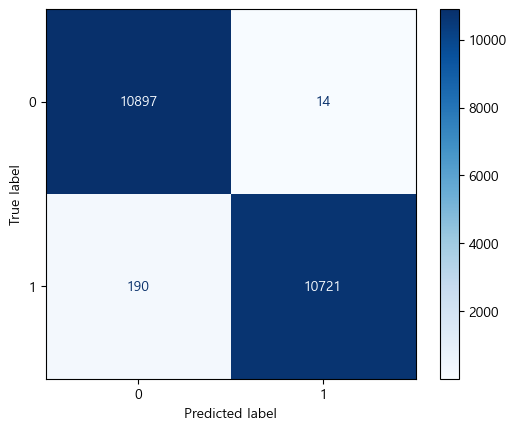

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# 혼동 행렬 계산
cm = confusion_matrix(y_te, pred_val)

# 출력
print("Confusion Matrix:\n", cm)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [88]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_te)

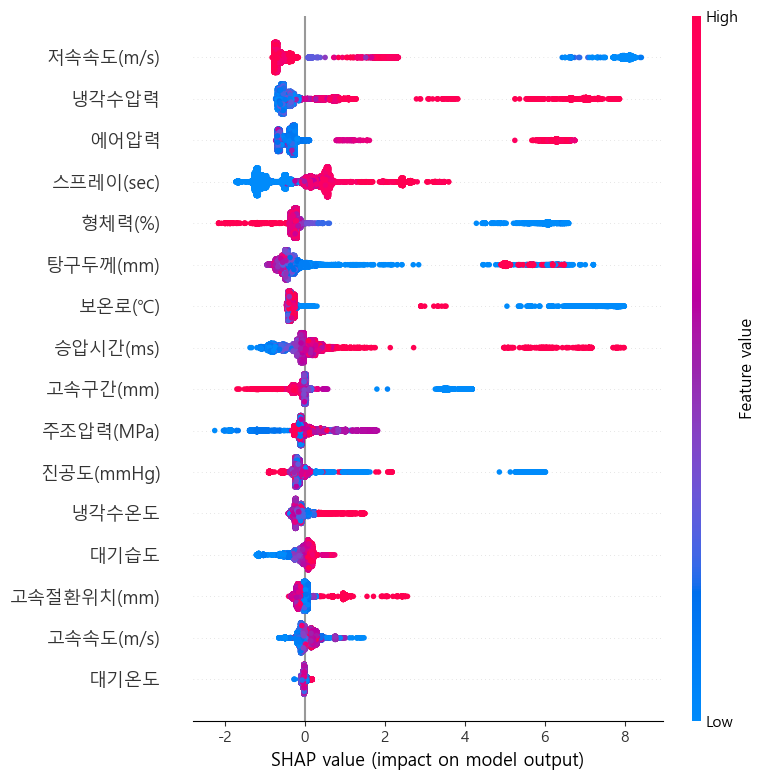

In [90]:
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values.values, X_te, feature_names=X_te.columns, show=False)
plt.tight_layout()
plt.show()


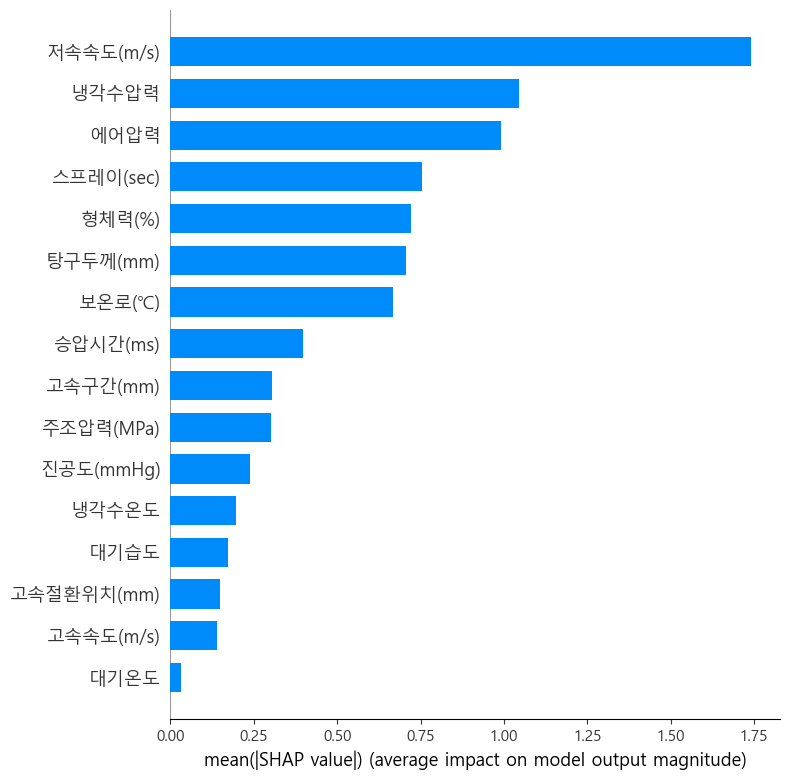

In [92]:
# === 전역 중요도: Bar Plot ===
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values.values, X_te, feature_names=X_te.columns,
                  plot_type="bar", show=False)
plt.tight_layout()
plt.show()

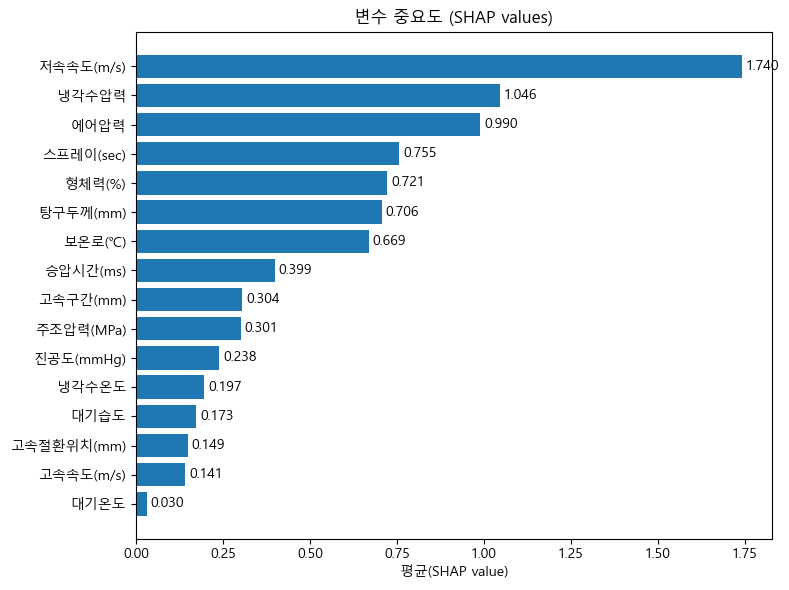

In [122]:
# 1. 각 변수별 평균 SHAP 절댓값 계산
shap_importance = np.abs(shap_values.values).mean(axis=0)
indices = np.argsort(shap_importance)  # 중요도 순 정렬

# 2. 가로 막대그래프
plt.figure(figsize=(8, 6))
bars = plt.barh(range(len(shap_importance)),
                shap_importance[indices],
                tick_label=X_te.columns[indices])

# 3. 막대 옆에 수치 표시 (오른쪽)
plt.bar_label(bars, fmt="%.3f", padding=3)

plt.xlabel("평균(SHAP value)")
plt.title("변수 중요도 (SHAP values)")
plt.tight_layout()
plt.show()


Top feature: 저속속도(m/s)


<Figure size 700x500 with 0 Axes>

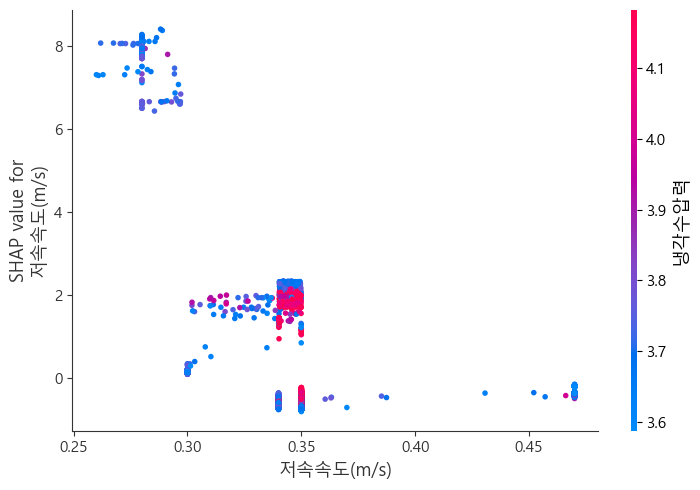

In [93]:
# === 부분 의존(상호작용) 보기: Dependence Plot ===
# 가장 영향 큰 피처 하나 자동 선택
mean_abs = np.abs(shap_values.values).mean(axis=0)
top_idx = int(np.argmax(mean_abs))
top_feat = X_te.columns[top_idx]
print("Top feature:", top_feat)

plt.figure(figsize=(7, 5))
shap.dependence_plot(top_feat, shap_values.values, X_te, show=False)
plt.tight_layout()
plt.show()

<Figure size 800x150 with 0 Axes>

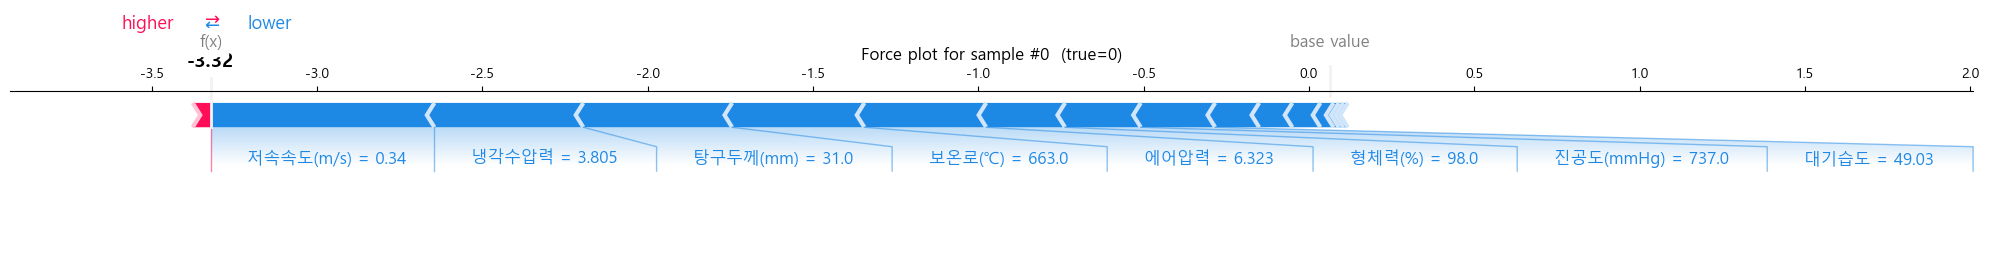

In [94]:
# === 개별 예측 로컬 설명: Force Plot (Matplotlib 정적 버전) ===
# 특정 샘플이 어떤 이유로 양성/음성 쪽으로 치우쳤는지 시각화
i = 0  # 보고 싶은 테스트 인덱스
plt.figure(figsize=(8, 1.5))
shap.force_plot(
    base_value=explainer.expected_value if np.isscalar(explainer.expected_value) else explainer.expected_value[0],
    shap_values=shap_values.values[i],
    features=X_te.iloc[i],
    matplotlib=True,
    show=False
)
plt.title(f"Force plot for sample #{i}  (true={y_te.iloc[i]})")
plt.tight_layout()
plt.show()